In [30]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import csv
import os

# import statments
import numpy as np
import numpy
import re
import sys
import math

def tokenize(sentences):
  words = []
  for sentence in sentences:
    w = word_extraction(sentence)
    words.extend(w)
  # words = sorted(list(set(words)))
  return words

def word_extraction(sentence):
  ignore = ['a', "the", "is"]
  words = re.sub("[^\w]", " ",  sentence).split()
  cleaned_text = [w.lower() for w in words if len(w)>2 and w not in ignore]
  return cleaned_text  

def generate_bow(allsentences):
  S=[]
  vocab = tokenize(allsentences)
  vocab = sorted(list(set(vocab)))
  print(len(vocab))

  for sentence in allsentences:
    words = word_extraction(sentence)
    bag_vector = numpy.zeros(len(vocab))

    for w in words:
        for i,word in enumerate(vocab):
            if word == w: 
                bag_vector[i] += 1
                      
    S.append(numpy.array(bag_vector))
    numpy.set_printoptions(threshold=sys.maxsize)
  return S, vocab

def sigmoid(score):
  return (1 / (1 + np.exp(-score)))

def predict_probability(features, weights):
  score = np.dot(features, weights)
  return sigmoid(score)



In [31]:
# feature derivative computation with L2 regularization
def l2_derivative_of_features(errors, feature, weight, l2_penalty, bias_term):
  derivative = np.dot(np.transpose(errors), feature)
  if not bias_term:
    derivative -= l2_penalty * weight
  return derivative

# log-likelihood computation with L2 regularization
def computing_log_likelihood(features, labels, weights, l2_penalty):
  actuals = (labels==+1)
  scores = np.dot(features, weights)
  ll = np.sum((np.transpose(np.array([actuals]))-1)*scores - np.log(1. + np.exp(-scores))) - (l2_penalty * np.sum(weights[1:]**2))
  return ll

# logistic regression with L2 regularization
def logistic_regression(features, labels, lr, epochs, l2_penalty):

  bias = np.ones((features.shape[0], 1))
  features = np.hstack((bias, features))

  # initialize the weight coefficients
  weights = np.zeros((features.shape[1], 1))
  train_logs = []
  epochs_count=0

  # loop over epochs times
  for epoch in range(epochs):
    # predict probability for each row in the dataset
    predictions = predict_probability(features, weights)
    actuals = (labels==+1)
    # calculate the errors
    errors = np.transpose(np.array([actuals])) - predictions
    
    for j in range(len(weights)):
      bias_term = (j==0)
      derivative = l2_derivative_of_features(errors, features[:,j], weights[j], l2_penalty, bias_term)
      weights[j] += lr * derivative

    # compute the log-likelihood
    ll = computing_log_likelihood(features, labels, weights, l2_penalty)
    train_logs.append(ll)

  import matplotlib.pyplot as plt
  x = np.linspace(0, len(train_logs), len(train_logs))
  fig = plt.figure()
  plt.plot(x, train_logs)
  fig.suptitle('Training the classifier')
  plt.xlabel('Epoch')
  plt.ylabel('Log-likelihood')
  fig.savefig('train_MCAP.jpg')
  plt.show()

  return weights

In [32]:
from sklearn.metrics import accuracy_score

def lr_with_regularization(X_train, y_train, X_test, y_test, learning_rate, epochs, l2_penalty = [1, 2, 3, 4]):
  
  test_accuracies=[]
  train_accuracies=[]
  for lambdaa in l2_penalty:
    # perform logistic regression and get the learned weights
    learned_weights = logistic_regression(X_train, y_train, learning_rate, epochs, lambdaa)

    bias_train = np.ones((X_train.shape[0], 1))
    bias_test = np.ones((X_test.shape[0], 1))

    features_train = np.hstack((bias_train, X_train))
    features_test = np.hstack((bias_test, X_test))

    test_predictions_single = (predict_probability(features_test, learned_weights).flatten()>0.5)
    train_predictions_single = (predict_probability(features_train, learned_weights).flatten()>0.5)

    train_accuracy = len([y_train[i] for i in range(0, len(y_train)) if y_train[i] == train_predictions_single[i]]) / len(y_train)
    # print("Training Accuracy", train_accuracy)

    test_accuracy = len([y_test[i] for i in range(0, len(y_test)) if y_test[i] == test_predictions_single[i]]) / len(y_test)
    # print("Testing Accuracy", test_accuracy)

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

  return test_accuracies, train_accuracies

In [33]:
def generate_bow_for_test(allsentences, vocab):
  S=[]

  for sentence in allsentences:
    words = word_extraction(sentence)
    bag_vector = numpy.zeros(len(vocab))

    for w in words:
        for i,word in enumerate(vocab):
            if word == w: 
                bag_vector[i] += 1
                      
    S.append(numpy.array(bag_vector))
    numpy.set_printoptions(threshold=sys.maxsize)
  return S


In [34]:
#dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
import os

def train():
  for d in os.listdir("Dataset/"):
    print(d)
    path = "Dataset/"+d+"/train/"
    dictionary=[]
    classes=['spam', 'ham']
    lbl=[]
    for i in classes:
      for j in os.listdir(path+i):

        file1 = open(path+i+"/"+j, errors="ignore")
        file=file1.read().split("\n")
        dictionary.append(' '.join(file))
        if i=='spam':
          lbl.append(1)
        else:
          lbl.append(0)

    print(len(dictionary))

    X, vocab=generate_bow(dictionary)
    y=lbl
    # split the dataset into training and testing 

    X=np.array(X, dtype=np.float128)
    y = np.array(y, dtype=np.float128)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=9)

    # hyper-parameters
    learning_rate = 0.0045
    epochs = 75
    l2_penalty = [1, 2, 3, 4]

    test_acc, train_acc = lr_with_regularization(X_train, y_train, X_test, y_test, learning_rate, epochs, l2_penalty)
    print("Training Accuracy", max(train_acc))  
    print("Validation Accuracy", max(test_acc))  

    lambdaa_max = l2_penalty[test_acc.index(max(test_acc))]
    print("Lambda Regularizer Best Value", lambdaa_max)

    learned_weights_full_train = logistic_regression(X, y, 0.0045, 75, lambdaa_max)
    bias_train_all = np.ones((X.shape[0], 1))
    features_train_all = np.hstack((bias_train_all, X))
    train_predictions_single = (predict_probability(features_train_all, learned_weights_full_train).flatten()>0.5)

    train_accuracy_all = len([y[i] for i in range(0, len(y)) if y[i] == train_predictions_single[i]]) / len(y)
    print("Training Accuracy on full data", train_accuracy_all)

    test_dictionary=[]
    classes=['spam', 'ham']
    lbl_test=[]
    path = "Dataset/"+d+"/test/"

    for i in classes:
      for j in os.listdir(path+i):

        file1 = open(path+i+"/"+j, errors="ignore")
        file=file1.read().split("\n")
        test_dictionary.append(' '.join(file))
        if i=='spam':
          lbl_test.append(1)
        else:
          lbl_test.append(0)

    print(len(test_dictionary))
    X_test_data=generate_bow_for_test(test_dictionary, vocab)
    y_test_data=lbl_test

    X_test_data = np.array(X_test_data, dtype=np.float128)
    y_test_data = np.array(y_test_data, dtype=np.float128)
    bias_test_data = np.ones((X_test_data.shape[0], 1))
    features_test_data = np.hstack((bias_test_data, X_test_data))
    test_predictions_single = (predict_probability(features_test_data, learned_weights_full_train).flatten()>0.5)

    test_accuracy = len([y_test_data[i] for i in range(0, len(y_test_data)) if y_test_data[i] == test_predictions_single[i]]) / len(y_test_data)
    print("Testing Accuracy on Test Data", test_accuracy)

    from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

    print(confusion_matrix(y_test_data, test_predictions_single))
    print(classification_report(y_test_data, test_predictions_single))

hw1
463
10028


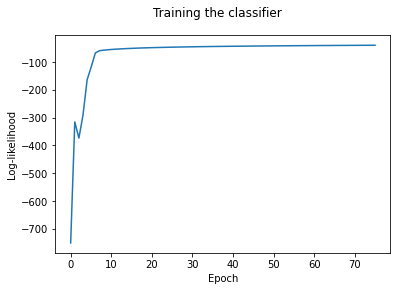

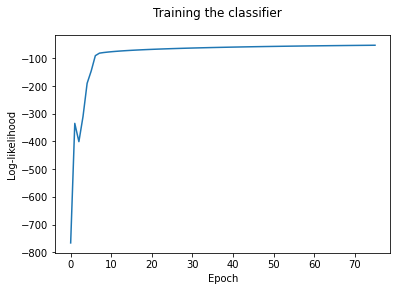

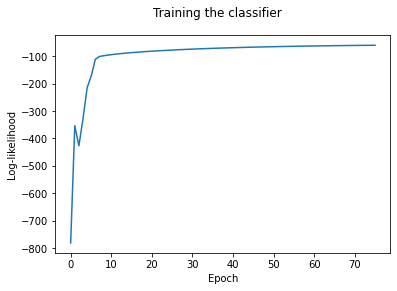

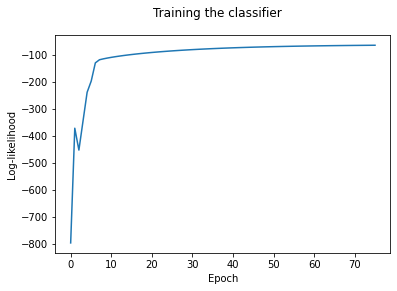

Training Accuracy 1.0
Lambda Regularizer Best Value 1


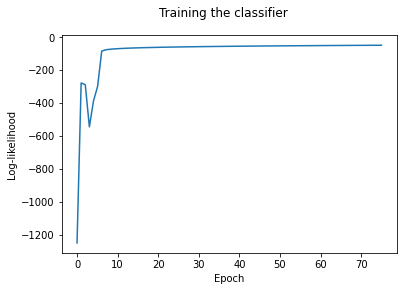

Training Accuracy on full data 1.0
478
Testing Accuracy on Test Data 0.9435146443514645
[[333  15]
 [ 12 118]]
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       348
         1.0       0.89      0.91      0.90       130

    accuracy                           0.94       478
   macro avg       0.93      0.93      0.93       478
weighted avg       0.94      0.94      0.94       478

enron1
450
9688


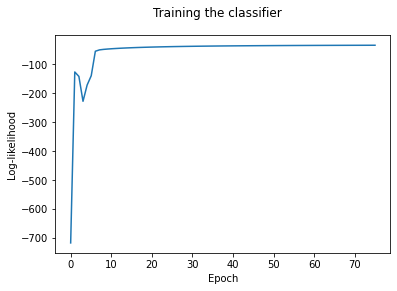

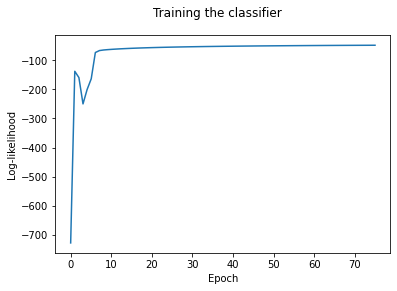

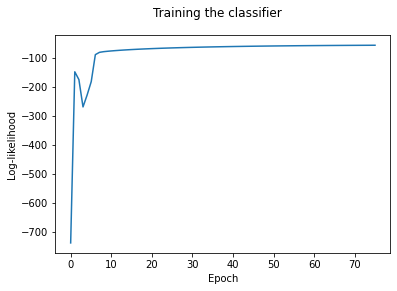

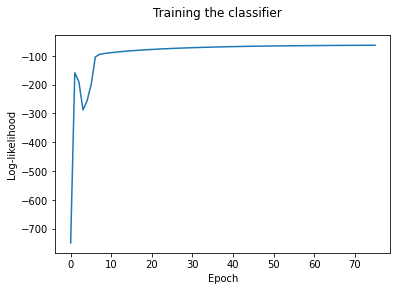

Training Accuracy 1.0
Lambda Regularizer Best Value 1


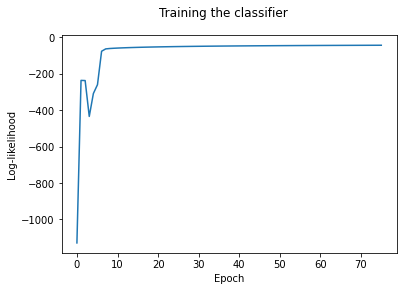

Training Accuracy on full data 1.0
456
Testing Accuracy on Test Data 0.9429824561403509
[[290  17]
 [  9 140]]
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96       307
         1.0       0.89      0.94      0.92       149

    accuracy                           0.94       456
   macro avg       0.93      0.94      0.94       456
weighted avg       0.94      0.94      0.94       456

enron4
535
17343


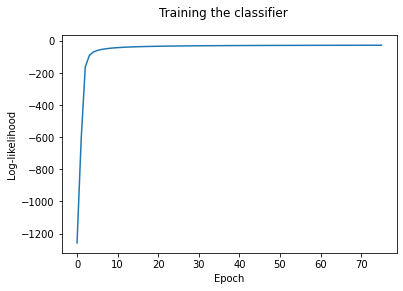

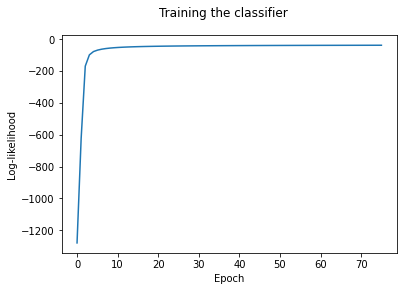

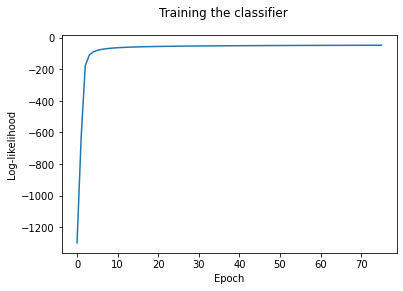

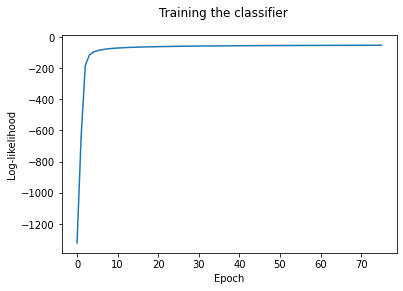

Training Accuracy 0.9976635514018691
Lambda Regularizer Best Value 1


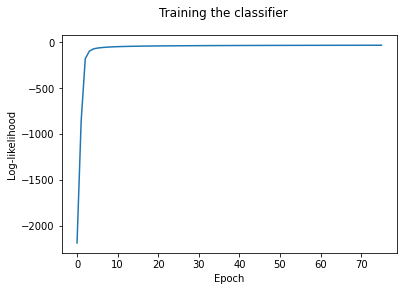

Training Accuracy on full data 0.9981308411214953
543
Testing Accuracy on Test Data 0.9760589318600368
[[140  12]
 [  1 390]]
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96       152
         1.0       0.97      1.00      0.98       391

    accuracy                           0.98       543
   macro avg       0.98      0.96      0.97       543
weighted avg       0.98      0.98      0.98       543



In [35]:
train()